# **Task 1** - Computer Vision & IOT: Optical Character Recognition (ORC)
+ **Creative Space:** Using OCR in extracting information from blood pressure reports.

**Author: Ramsis Hammadi**

---
As an IOT/Computer Visions Intern at the Graduate Rotational Internship program (GRIP) by The Sparks Foundation (TSF), the first task is to **implement a character detector** which **extracts printed or handwritten text from an image/video.**

For more learning purposes, I've utilized this feature in **extracting clean data from Blood Pressure Reports** as images. 


# **Dependencies**




<h5>
<li>tesseract-ocr package
<li>pytesseract 0.3.8
<li>Open-cv
<li>Pandas
<h5>


---
Using the pytesseract open source library to detect text on image/video.

Open-cv for Image Processing

Pandas for data manipulation










In [1]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10-1 cuda-nsight-11-0 cuda-nsight-11-1 cuda-nsight-compute-10-0
  cuda-nsight-compute-10-1 cuda-nsight-compute-11-0 cuda-nsight-compute-11-1
  cuda-nsight-systems-10-1 cuda-nsight-systems-

In [2]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import pandas as pd
import pytesseract


import matplotlib.pyplot as plt

%matplotlib inline

img = cv2.imread("Blood_Pressure_Report.jpg")

In [3]:

def process_image(img):
    #Using Open-cv algorithms to denoise the image
    return cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)


def extract_coords_n_boxes(img, n = -1):
  #Extracting the n-box coords
  processed_img = process_image(img)
  boxes = pytesseract.image_to_boxes(processed_img)
  coords = [cl[2:].split(" ") for cl in boxes.split("0\n")]

  try:
    dig_n = [[int(i) for i in x[:-1]] for x in coords[:n] ]
  except:
    dig_n = [[int(i) for i in x[:-1]] for x in coords[:-1] ]
  
  box_coords = [[(rec[i], img.shape[0] - rec[i+1]) for i in range(0, 3, 2)] for rec in dig_n]
  
  return box_coords

def draw_boxes(img):
  
  boxes = extract_coords_n_boxes(img)
  #drawing the boxes on the image
  for box in boxes:
    cv2.rectangle(img, box[0], box[1], (0, 255 , 0), 1 )
  cv2_imshow(img)


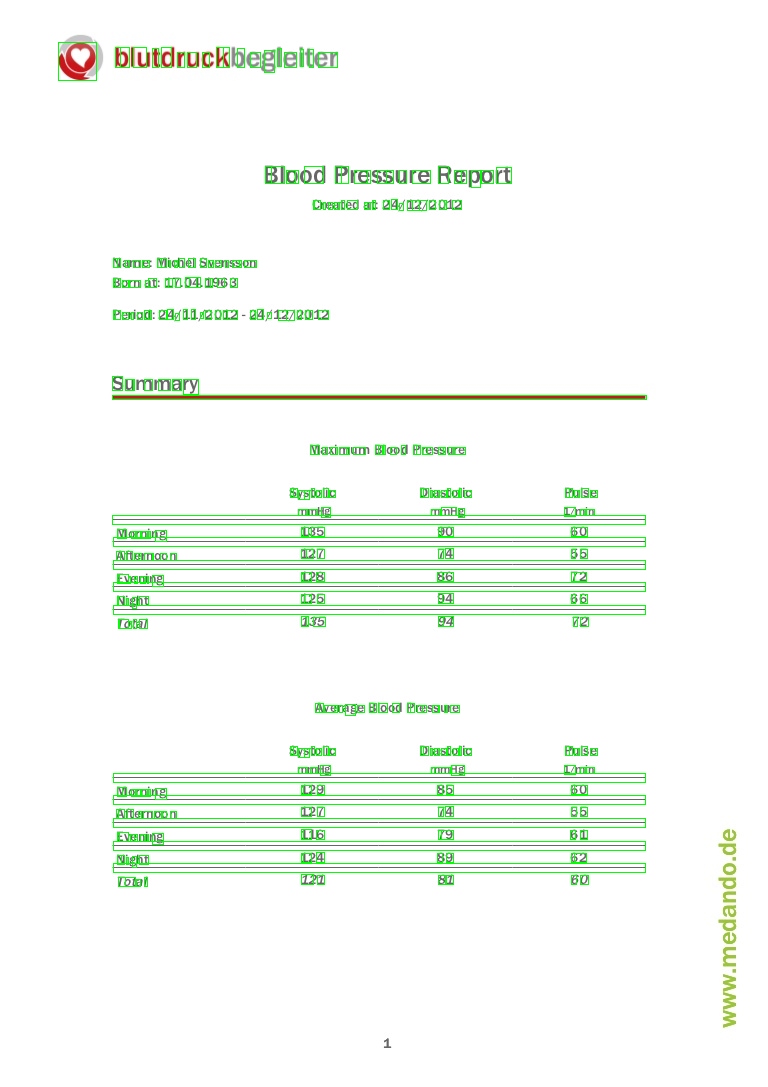

In [4]:
#drawing each predicted character box on the image
draw_boxes(img)

In [5]:
#Exracting the information from the image as a DataFrame
df = pytesseract.image_to_data('Blood_Pressure_Report.jpg', output_type=pytesseract.Output.DATAFRAME)

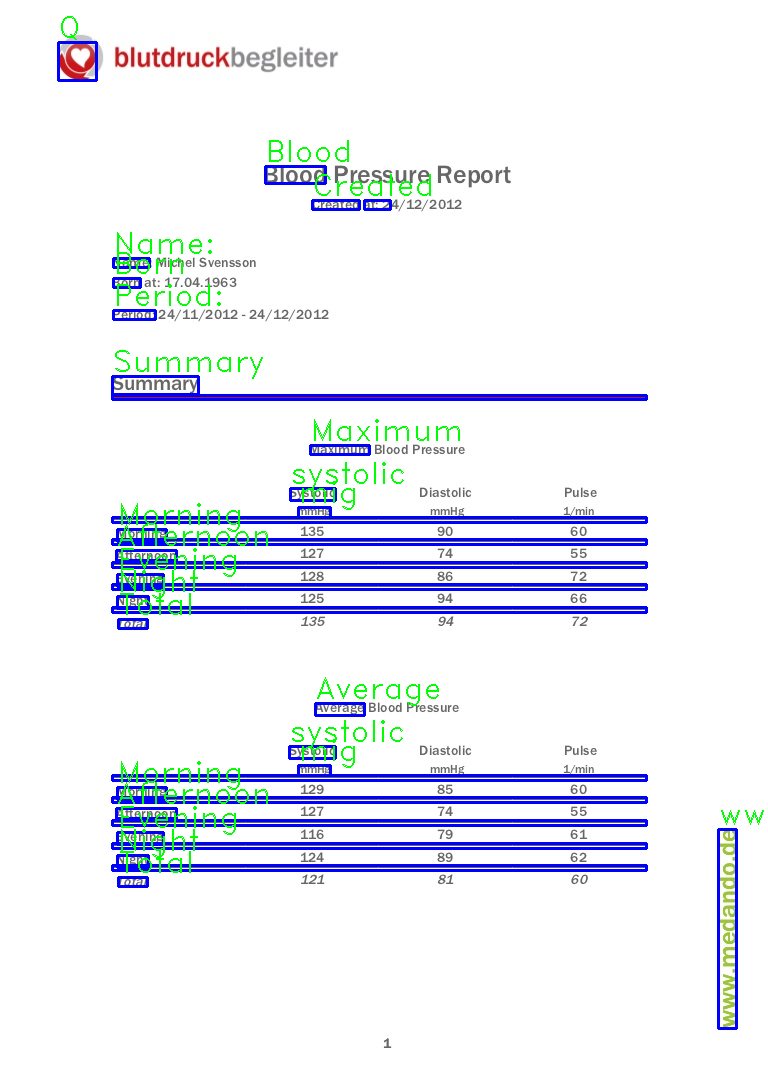

In [6]:
#Re-calling the initial state of the image before drawing boxes
img = cv2.imread("Blood_Pressure_Report.jpg")
#Using a different method to draw boxes on WORDS and type their meaning on top of them
for i, row in df[df.word_num==1].iterrows():
    xmax = row.left+ row.width # left + width (xmax)
    ymax =row.top + row.height # top + height (ymax)
    cv2.rectangle(
        img, (row.left, row.top), 
        (xmax, ymax), (255, 0, 0), 2
    )
    # write detected text of block
    cv2.putText(img, row[11], (row.left, row.top - 5), cv2.FONT_HERSHEY_DUPLEX, 1, (0, 255, 0), 1)

cv2_imshow(img)

In [12]:
print(text)

Q blutdruckbegleiter

Blood Pressure Report

Created at: 24/12/2012

 

Name: Michel Svensson
Born at: 17.04.1963

Period: 24/11/2012 - 24/12/2012

 

 

 

 

 

 

 

 

 

 

 

Summary
Maximum Blood Pressure
systolic Diastolic Pulse
mig mms ymin
Morning 135 90 60
Afternoon 127 74 55
Evening 128 86 72
Night 125 94 66
Total 135 94 72
Average Blood Pressure
systolic Diastolic Pulse
mig mig ymin
Morning 129 85 60
Afternoon 127 74 55
Evening 116 79 61
Night 124 89 62
Total 124 84 60

www.medando.de



In [7]:
def extraction(text):
  
  #Cleaning
  lst = text.split('\n')
  lst = list(filter(lambda x: True if (x not in ['', ' ']) else False, lst))

  #Mapping through the information needed
  report = {'title' : lst[1]}
  for txt in lst[: lst.index("Summary")]:
    if("Name" in txt):
      report['Name']= txt[txt.find(':') + 2 :]
    elif('Born' in txt):
      report['birth'] = txt[txt.find(":") + 2: ]
    elif('Period' in txt):
      report['Period'] = txt[txt.find(':') + 2: ]
  
  #Maximum Blood Pressure
  info_stack = [x.split() for x in lst[lst.index('Summary')+2: lst.index('Average Blood Pressure')]]
  report['Maximum Blood Pressure'] = pd.DataFrame(info_stack[2:], columns = [' '] + info_stack[0])

  #Average Blood Pressure
  info_stack = [x.split() for x in lst[lst.index('Average Blood Pressure')+1: -2]]
  report['Average Blood Pressure'] = pd.DataFrame(info_stack[2:], columns = [' '] + info_stack[0])

  report['Source'] = lst[-2]

  #Return the final report with all information needed
  return report

In [8]:
img = cv2.imread("Blood_Pressure_Report.jpg")
text = pytesseract.image_to_string(img)
full_report = extraction(text)
full_report

{'Average Blood Pressure':              systolic Diastolic Pulse
 0    Morning      129        85    60
 1  Afternoon      127        74    55
 2    Evening      116        79    61
 3      Night      124        89    62
 4      Total      124        84    60,
 'Maximum Blood Pressure':              systolic Diastolic Pulse
 0    Morning      135        90    60
 1  Afternoon      127        74    55
 2    Evening      128        86    72
 3      Night      125        94    66
 4      Total      135        94    72,
 'Name': 'Michel Svensson',
 'Period': '24/11/2012 - 24/12/2012',
 'Source': 'www.medando.de',
 'birth': '17.04.1963',
 'title': 'Blood Pressure Report'}

In [9]:
full_report.keys()

dict_keys(['title', 'Name', 'birth', 'Period', 'Maximum Blood Pressure', 'Average Blood Pressure', 'Source'])

In [11]:
full_report['Average Blood Pressure']

,,systolic,Diastolic,Pulse
0,Morning,129,85,60
1,Afternoon,127,74,55
2,Evening,116,79,61
3,Night,124,89,62
4,Total,124,84,60


# **Thank you!**
---**Ramsis Hammadi**, Data Scientist & Competitive Programming Instructor.

If you wish to join the GRIP Program, do apply here:
https://internship.thesparksfoundation.info/ 